# Lecture 8: Portfolio theory and PCA analysis

In [1]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sco
%matplotlib inline

### Loading data for portfolio analysis

In [2]:
path = "data/L8_Data.csv"
data = pd.read_csv(path)
data = data.set_index('Date')
data.head()

,AAPL,MSFT,YHOO,DB,GLD
Date,,,,,
2010-01-04,28.588685,26.593966,17.100000,61.392277,109.800003
2010-01-05,28.638111,26.602557,17.230000,62.565957,109.699997
2010-01-06,28.182584,26.439299,17.170000,61.484485,111.510002
2010-01-07,28.130486,26.164338,16.700001,62.180321,110.820000
2010-01-08,28.317506,26.344781,16.700001,64.427088,111.370003


In [3]:
# returns = np.log(data/data.shift(1)).reset_index() # compute log-returns
returns = np.log(data/data.shift(1))

no_assets = len(returns.columns.tolist())
print("No assets=", no_assets)
returns.head()

No assets= 5


,AAPL,MSFT,YHOO,DB,GLD
Date,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN
2010-01-05,0.001727,0.000323,0.007574,0.018937,-0.000911
2010-01-06,-0.016034,-0.006156,-0.003488,-0.017436,0.016365
2010-01-07,-0.001850,-0.010454,-0.027755,0.011254,-0.006207
2010-01-08,0.006626,0.006873,0.000000,0.035496,0.004951


In [4]:
returns.mean()

AAPL    0.001060
MSFT    0.000454
YHOO    0.000778
DB     -0.000497
GLD     0.000064
dtype: float64

## Monte Carlo portfolios

In [5]:
weights = np.random.rand(no_assets) # random weights
weights /= np.sum(weights) # normalize weights
returns.mean() * weights

AAPL    0.000155
MSFT    0.000076
YHOO    0.000158
DB     -0.000043
GLD     0.000025
dtype: float64

In [6]:
MC_returns = [] # return vector
MC_vols = [] # volatility vector
N = 2500 # number of portfolios

for p in range(N):
    weights = np.random.rand(no_assets) # random weights
    weights /= np.sum(weights) # normalize weights
    MC_returns.append(np.sum(returns.mean() * weights) * 252) # compute expected returns (annual)
    MC_vols.append(np.sqrt(np.dot(weights.T,
                                  np.dot(returns.cov()*252,
                                         weights)))) # compute volatility (annual)

MC_returns = np.array(MC_returns)
MC_vols = np.array(MC_vols)

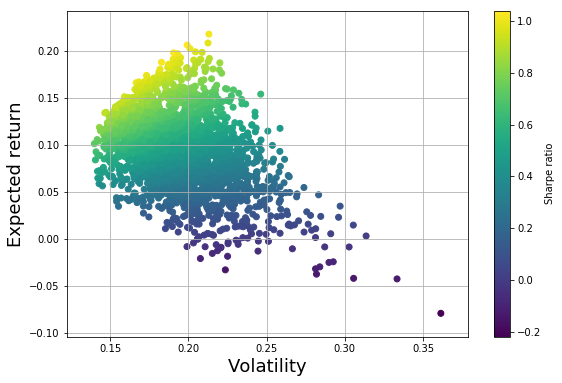

In [7]:
plt.figure(figsize=(9,6))
plt.scatter(MC_vols, MC_returns, c=MC_returns/MC_vols, marker='o')
plt.grid()
plt.xlabel('Volatility', fontsize=18)
plt.ylabel('Expected return', fontsize=18)
plt.colorbar(label='Sharpe ratio')

### Portfolio summary measures

In [8]:
def portfolio(weights):
    weights = np.array(weights)
    P_ret = np.sum(returns.mean() * weights)*252
    P_vol = np.sqrt(np.dot(weights.T,
                           np.dot(returns.cov()*252,
                                             weights)))
    return np.array([P_ret, P_vol, P_ret/P_vol])

### Maximum Sharpe Ratio portfolio

In [9]:
def Sharpe(weights):
    return -portfolio(weights)[2]

cons = ({'type':'eq', 'fun':lambda x: np.sum(x)-1})
bnds = tuple((0,1) for x in range(no_assets))

opt_S = sco.minimize(Sharpe, no_assets*[1.0/no_assets], method='SLSQP', bounds=bnds, constraints=cons)

print(opt_S['x'].round(3)) # weights

portfolio(opt_S['x']) # statistics

[0.662 0.086 0.252 0.    0.   ]


array([0.23603956, 0.22204861, 1.06300848])

### Minimum variance portfolio

In [10]:
def Variance(weights):
    return portfolio(weights)[1]**2

opt_V = sco.minimize(Variance, no_assets*[1.0/no_assets], method='SLSQP', bounds=bnds, constraints=cons)

print(opt_V['x'].round(3)) # weights
portfolio(opt_V['x']) # statistics

[0.108 0.249 0.109 0.    0.534]


array([0.08726149, 0.13523313, 0.64526711])

## Plotting the efficient frontier

In [11]:
TargetRet = np.linspace(0.0,0.25,50) # range for target returns
MinVols = []

for tret in TargetRet:
    cons = ({'type':'eq', 'fun':lambda x: portfolio(x)[0]-tret},{'type':'eq', 'fun':lambda x: np.sum(x)-1})
    res = sco.minimize(lambda x: portfolio(x)[1], no_assets*[1.0/no_assets], method='SLSQP', bounds=bnds, constraints=cons)
    MinVols.append(res['fun'])

Text(0,0.5,'Expected return')

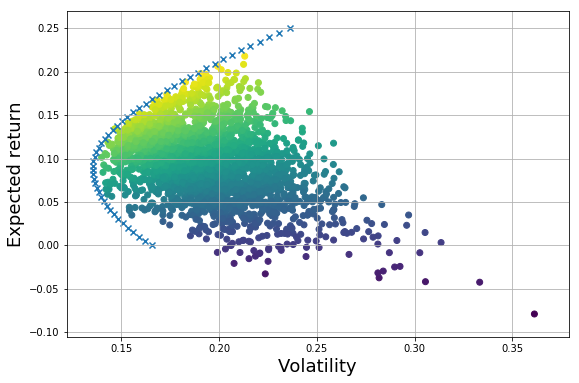

In [12]:
plt.figure(figsize=(9,6))
plt.scatter(MC_vols, MC_returns, c=MC_returns/MC_vols, marker='o')
plt.scatter(MinVols, TargetRet, marker='x')
plt.grid()
plt.xlabel('Volatility', fontsize=18)
plt.ylabel('Expected return', fontsize=18)

## Plotting the Capital Market Line (CML)

1. Let $t(x)=a+b\times x$ be the linear CML.
2. Let $f(x)$ be the efficient frontier EF.
3. Let $x^\star$ be the tangency portfolio.

At the tangency portfolio, CML and EF have:
1. equal values $t(x^\star)=f(x^\star)$
2. equal first derivatives $t^\prime(x^\star)=f^\prime(x^\star)$

### Numerical interpolation of the efficient frontier and its slope

In [13]:
import scipy.interpolate as sci

ind = np.argmin(MinVols) # minimum variance portfolio index

erets = TargetRet[ind:] # all portfolios on the "positive" side of EF
evols = MinVols[ind:]

tck = sci.splrep(evols,erets) # interpolate a spline

def f(x): # evaluate the spline
    return sci.splev(x,tck,der=0)
def df(x): # evaluate the first derivative of the spline
    return sci.splev(x,tck,der=1)

In [14]:
def equations(p, rf=0.01):
    eq1 = rf - p[0] # CML starts at RF rate
    eq2 = rf + p[1] * p[2] - f(p[2]) # RF rate + slope * tangency vol = EF at tangency vol
    eq3 = p[1] - df(p[2]) # CML slope = EF slope at tangency vol
    return eq1, eq2, eq3

opt = sco.fsolve(equations, [0.01, 0.5, 0.15])

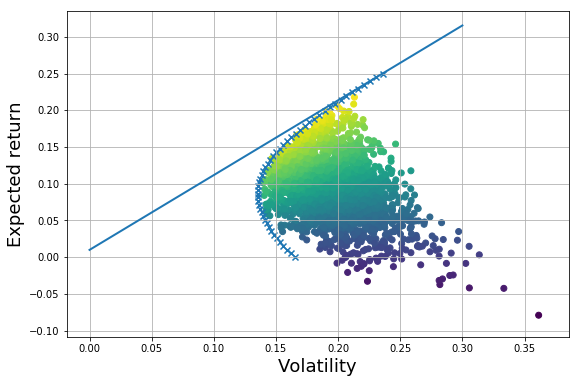

In [15]:
plt.figure(figsize=(9,6))

plt.scatter(MC_vols, MC_returns, c=MC_returns/MC_vols, marker='o')
plt.scatter(MinVols, TargetRet, marker='x')

plt.grid()
plt.xlabel('Volatility', fontsize=18)
plt.ylabel('Expected return', fontsize=18)

cx = np.linspace(0.0,0.3)
plt.plot(cx, opt[0]+opt[1]*cx, lw=2)

## Principal Component Analysis

In [16]:
# Dataframe with all CAC40 components
pathCAC = "data/L8_DataCAC.csv"
DataCAC = pd.read_csv(pathCAC).set_index('Date')
print(DataCAC.shape)
DataCAC.head()

(325, 40)


,AC.PA,ACA.PA,AI.PA,AIR.PA,ALO.PA,ALU.PA,BN.PA,BNP.PA,CA.PA,CAP.PA,...,SAF.PA,SAN.PA,SGO.PA,SU.PA,TEC.PA,UG.PA,UL.PA,VIE.PA,VIV.PA,^FCHI
Date,,,,,,,,,,,,,,,,,,,,,
2012-02-28,23.4611,4.4521,72.3104,25.485,29.968,1.894,45.7406,31.9904,15.816,29.175,...,22.65644,48.246,30.489,44.2136,75.81611,11.0945,120.1574,7.177,12.397,3453.989990
2012-02-29,23.7263,4.5515,72.1108,25.555,30.244,1.882,45.8128,32.0079,16.266,29.871,...,23.14877,47.910,30.613,44.6248,74.51552,10.8599,120.5314,7.327,12.241,3452.449951
2012-03-01,24.0588,4.6424,73.1977,26.291,30.276,1.805,46.2819,32.6369,16.309,29.885,...,23.71012,49.325,31.099,45.7533,76.85294,10.4412,122.5264,8.416,11.011,3499.729980
2012-03-02,24.1442,4.6822,72.6432,25.916,30.332,1.829,45.9752,33.1262,16.313,30.300,...,23.64570,49.507,31.236,45.8058,76.24358,10.4881,122.7758,8.815,10.905,3501.169922
2012-03-05,23.8341,4.5923,73.1533,25.747,30.103,1.770,46.6699,32.5365,16.162,30.034,...,23.94938,49.731,30.587,44.9485,75.07941,10.2535,122.3602,8.731,10.745,3487.540039


In [17]:
# Take out the actual CAC40 index
# cac40 = DataCAC['^FCHI'].reset_index()
cac40 = DataCAC.pop("^FCHI")
cac40 = cac40.reset_index()
DataCAC.shape

(325, 39)

In [18]:
cac40.set_index('Date').head()

,^FCHI
Date,
2012-02-28,3453.989990
2012-02-29,3452.449951
2012-03-01,3499.729980
2012-03-02,3501.169922
2012-03-05,3487.540039


In [19]:
def normalize(x):
    return (x-x.mean())/x.std() # normalization function

## Principal component analysis: 
Find a weight vector ($\omega$), i.e., portfolio weights, that maximize the total variance across a matrix $X$:
\begin{equation}
\omega^\star_1 = \arg \max \frac{\omega^T X^T X \omega}{\omega^T \omega}
\end{equation}
It follows that $\omega^\star_1$ is the eigenvector corresponding to largest eigenvalue of the (covariance) matrix $X^T X$.

The second (and following) PCs are estimated by substracting the previous results:
$$\hat{X}_2=X-X\omega^\star_1\omega^{\star,T}_1$$
and then
\begin{equation}
\omega^\star_2 = \arg \max \frac{\omega^T \hat{X}^T_2 \hat{X}_2 \omega}{\omega^T \omega}
\end{equation}

In [20]:
from sklearn.decomposition import KernelPCA
pca = KernelPCA().fit(DataCAC.apply(normalize))

pca.lambdas_[:10]

array([7757.54613373, 1667.56152778, 1030.79917209,  823.20177463,
        319.51885679,  221.91755558,  166.35023717,  148.19980509,
         97.2690799 ,   66.16986514])

In [21]:
def fractions(x):
    return x/x.sum() # normalize sum to one

var_ratio = fractions(pca.lambdas_)[:10] # normalize eigenvalues

var_ratio

array([0.6139242 , 0.1319691 , 0.08157638, 0.06514734, 0.02528639,
       0.01756233, 0.01316479, 0.01172838, 0.00769777, 0.00523661])

In [22]:
var_ratio[:5].sum().round(3)

0.918

In [23]:
pca_1 = KernelPCA(n_components=1).fit(DataCAC.apply(normalize))

In [24]:
# pca.transform(-DataCAC.set_index('Date'))
cac40['PCA_1'] = pca_1.transform(-DataCAC)

In [25]:
cac40.head()

,Date,^FCHI,PCA_1
0,2012-02-28,3453.989990,-235.386185
1,2012-02-29,3452.449951,-235.772819
2,2012-03-01,3499.729980,-239.369014
3,2012-03-02,3501.169922,-239.505512
4,2012-03-05,3487.540039,-238.959876


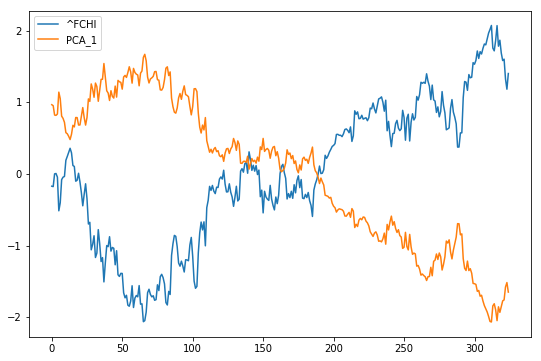

In [26]:
cac40[['^FCHI','PCA_1']].apply(normalize).plot(figsize=(9,6))

In [27]:
pca_5 = KernelPCA(n_components=5).fit(DataCAC.apply(normalize))

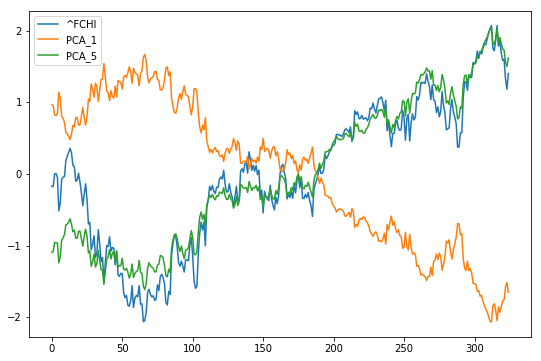

In [28]:
pca_components = pca_5.transform(-DataCAC)
weights = fractions(pca_5.lambdas_)
cac40['PCA_5'] = np.dot(pca_components, weights)
cac40[['^FCHI','PCA_1','PCA_5']].apply(normalize).plot(figsize=(9,6))

In [29]:
print(pca_components, "\n", weights)

[[235.38618504   2.66494453 -52.24300273  23.03423386  28.21016573]
 [235.77281885   2.42476325 -51.37573857  22.76986729  28.35992258]
 [239.36901386   2.32224255 -52.33154194  23.45301363  28.22007017]
 ...
 [305.59775071  12.37568911 -37.28602991  42.11180788  28.98181657]
 [303.90040044  11.90777313 -36.47956344  42.38314152  29.26431425]
 [307.57627772  11.00602622 -37.29411617  43.07350568  29.06879544]] 
 [0.66883311 0.14377232 0.08887251 0.07097407 0.02754799]


## Tests for data normality

### Benchmark: Simulated data

In [30]:
def gen_paths(S0,r,sigma, T,M,I):

    dt = float(T)/M
    paths = np.zeros((M+1, I))
    paths[0] = S0
    for t in range(1,M+1):
        rand = np.random.randn(I)
        paths[t] = paths[t-1]*np.exp((r-0.5*sigma**2)*dt+sigma*np.sqrt(dt)*rand)
    return paths

paths = gen_paths(100,0.05,0.2,1.0,50,10000)
log_returns = np.log(paths[1:]/paths[0:-1])

In [31]:
log_returns[:, 0].round(4)

array([-0.0547, -0.0505,  0.0314,  0.0045,  0.0104, -0.0339,  0.0161,
       -0.0043,  0.0258, -0.0173,  0.0067,  0.014 , -0.0096,  0.001 ,
       -0.0006,  0.0013,  0.0581,  0.025 ,  0.032 , -0.0297, -0.0018,
       -0.0121,  0.0054,  0.0361,  0.033 ,  0.0354,  0.0254,  0.04  ,
       -0.0699,  0.0044, -0.0345,  0.0434, -0.0344,  0.0186, -0.0085,
        0.0204,  0.0078,  0.0215, -0.022 ,  0.0296,  0.0083,  0.0637,
        0.008 ,  0.0309, -0.07  ,  0.041 , -0.0114, -0.0055,  0.0077,
        0.0155])

Text(0.5,0,'Simulated return')

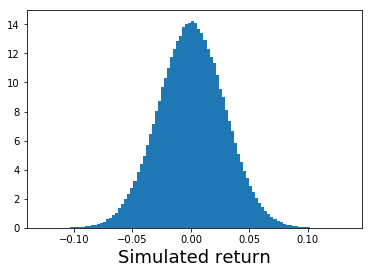

In [32]:
plt.hist(log_returns.flatten(),bins=100, density=True)
plt.xlabel("Simulated return", fontsize=18)

Text(0,0.5,'Sample quantiles')

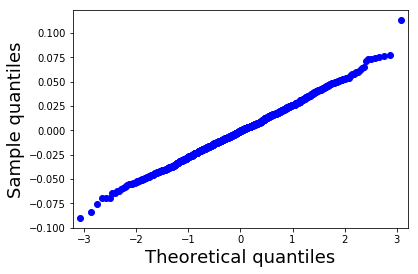

In [33]:
import statsmodels.api as sm

sm.qqplot(log_returns.flatten()[:1000])
plt.xlabel("Theoretical quantiles", fontsize=18)
plt.ylabel("Sample quantiles", fontsize=18)

In [34]:
# Testing for skewness, kurtosis, and normality
import scipy.stats as scs
print(scs.skew(log_returns.flatten()), scs.skewtest(log_returns.flatten()))
print(scs.kurtosis(log_returns.flatten()), scs.kurtosistest(log_returns.flatten()))
print(scs.normaltest(log_returns.flatten()))

0.0003226392797310365 SkewtestResult(statistic=0.09313933209682183, pvalue=0.9257928707329204)
0.0009685896905544666 KurtosistestResult(statistic=0.1449351041833477, pvalue=0.8847621099218663)
NormaltestResult(statistic=0.02968111960807992, pvalue=0.9852690185657731)


## CAC40 returns

In [35]:
log_cacreturns = np.log(cac40['^FCHI']/cac40['^FCHI'].shift(1))
log_cacreturns = log_cacreturns.values
log_cacreturns[:10]

array([        nan, -0.00044597,  0.01360171,  0.00041136, -0.00390055,
       -0.03649402,  0.00881442,  0.02504393,  0.00261846,  0.00073954])

Text(0.5,0,'CAC40 return')

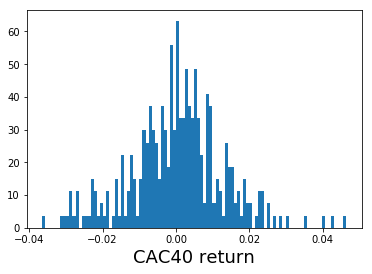

In [36]:
plt.hist(log_cacreturns[1:], bins=100, density=True)
plt.xlabel("CAC40 return", fontsize=18)

Text(0,0.5,'CAC40 return quantiles')

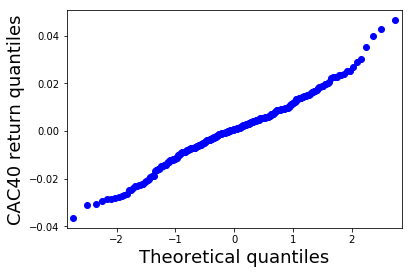

In [37]:
sm.qqplot(log_cacreturns[1:])
plt.xlabel("Theoretical quantiles", fontsize=18)
plt.ylabel("CAC40 return quantiles", fontsize=18)

In [38]:
print(scs.skew(log_cacreturns[1:]))
print(scs.skewtest(log_cacreturns[1:]))

0.06523759861356976
SkewtestResult(statistic=0.48943867188272683, pvalue=0.6245311631089383)


In [39]:
print(scs.kurtosis(log_cacreturns[1:]))
print(scs.kurtosistest(log_cacreturns[1:]))

0.9020196851490128
KurtosistestResult(statistic=2.6344290594757678, pvalue=0.008427891322684984)


In [40]:
print(scs.normaltest(log_cacreturns[1:]))

NormaltestResult(statistic=7.179766682944706, pvalue=0.02760155019164505)
